In [1]:
image_size   = 28
channels     = 1
class_num    = 10
output_dim   = 64
weight_decay = 0.01
batch_size   = 256
epochs       = 40

In [30]:
#**************************************************************************
#************************  prototype_layer.py  ****************************
#**************************************************************************

### special layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class BinarizedPrototypeLoss(tf.keras.layers.Layer):
  
    def __init__(self, num_classes=1, dim_hidden=1, lambda_c=1.0, **kwargs):
        super().__init__(**kwargs)
        self.dim_hidden  = dim_hidden
        self.num_classes = num_classes
        self.lambda_c    = tf.constant(lambda_c, dtype=tf.float32)       
        self.epsilon     = tf.constant(1e-6, dtype=tf.float32)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.num_classes, self.dim_hidden),
                                       initializer=tf.keras.initializers.RandomUniform(minval=0., maxval=1.),
                                       trainable=True)   
        super().build(input_shape)

    def call(self, inputs, mask=None):
        embedding, labels   = inputs[0], inputs[1]
        labels_int          = tf.math.argmax(labels, axis=1) 
        batch_size          = embedding.shape[0]
        if batch_size is None:
            batch_size = 1
        expanded_centers    = tf.expand_dims(self.centers, axis=0)   
        expanded_centers    = tf.repeat( expanded_centers, repeats=[batch_size], axis=0 )        
        expanded_embedding  = tf.expand_dims( embedding, axis=1 )
        expanded_embedding  = tf.repeat( expanded_embedding, repeats=[self.num_classes], axis=1 ) 
        distance_centers    = tf.math.squared_difference( expanded_embedding, expanded_centers )
        distance_centers    = tf.math.reduce_sum( distance_centers, axis=2 )
        # Contrastive Center 
        distances_intra     = tf.gather( distance_centers, indices=tf.expand_dims(labels_int, axis=1), batch_dims=1 )
        distances_sum       = tf.math.reduce_sum( distance_centers, axis=1 )
        distances_sum       = tf.expand_dims( distances_sum, axis=0 )
        distances_sum       = tf.transpose( distances_sum )
        distance_inter      = distances_sum - distances_intra
        loss1               = distances_intra/( distance_inter+self.epsilon)#self.lambda_c ) 
        # Cross Entropy over distance distribution
        loss2               = tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(labels, -1.0*distance_centers)
        loss2               = tf.expand_dims(loss2, axis=0)  
        loss2               = tf.transpose(loss2)
        # Regularization for output discritization
        # *********** for features discritization *******************    
        e                   = tf.ones([batch_size, self.dim_hidden] )
        dif                 = tf.linalg.matmul(embedding, e-embedding, transpose_b=True)
        loss3               = tf.linalg.tensor_diag_part(dif)
        loss3               = tf.expand_dims(loss3, axis=0)  
        loss3               = tf.transpose(loss3)
        # *********** for prototypes discritization *******************    
        ec                  = tf.ones([self.num_classes, self.dim_hidden] )
        difc                = tf.linalg.matmul(self.centers, ec-self.centers, transpose_b=True)
        loss3c              = tf.linalg.tensor_diag_part(difc)
        loss3c              = tf.math.reduce_sum( loss3c, axis=0 )
        # Final loss
        self.loss            = 100.0*loss1 + 10.0*loss2 + 0.01*loss3 + 0.001*loss3c
        return self.loss

    def compute_output_shape(self, input_shape):
        return tf.compat.v1.keras.backend.int_shape(self.loss)

### custom loss
def zero_loss(y_true, y_pred):
    return 0.5 * tf.math.reduce_sum(y_pred, axis=0)

In [31]:
#**************************************************************************
#******************************  model.py  ********************************
#**************************************************************************

from tensorflow.keras.regularizers import L2

### prelu
def prelu(x, name='default'):
    if name == 'default':
        return layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(x)
    else:
        return layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25), name=name)(x)

### model
def create_model(x, labels):
    x = layers.BatchNormalization()(x)
    #***********************************************************************
    x = layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=L2(weight_decay))(x)
    x = prelu(x)
    x = layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=L2(weight_decay))(x)
    x = prelu(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    #***********************************************************************
    x = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=L2(weight_decay))(x)
    x = prelu(x)
    x = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=L2(weight_decay))(x)
    x = prelu(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    #***********************************************************************
    x = layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=L2(weight_decay))(x)
    x = prelu(x)
    x = layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=L2(weight_decay))(x)
    x = prelu(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
    #***********************************************************************
    x = layers.Flatten()(x)
    x = layers.Dense(output_dim, activation='sigmoid', name='main_out')(x)
    #***********************************************************************
    side = layers.Dense(class_num, activation='softmax', name='side_out', kernel_regularizer=L2(weight_decay))(x)
    main = BinarizedPrototypeLoss(num_classes=class_num, dim_hidden=output_dim, name='BinarizedPrototype')([x, labels])
    return side, main

In [32]:
### compile
aux_input = layers.Input((image_size, image_size, channels))
main_input = layers.Input((class_num,))

side_output, final_output = create_model(aux_input, main_input)

model = tf.keras.models.Model(inputs=[aux_input, main_input], outputs=[side_output, final_output])
#model.summary()

In [33]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0001) #tf.keras.optimizers.SGD(lr=initial_learning_rate, momentum=0.9)

model.compile(optimizer=optim,
              loss=[tf.keras.losses.CategoricalCrossentropy(), zero_loss],
              loss_weights=[0.05, 0.95],
              metrics=["acc"])

In [34]:
### get data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, 28, 28, 1))/255
x_test = x_test.reshape((-1, 28, 28, 1))/255
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

In [35]:
### fit
dummy1 = np.zeros((x_train.shape[0], 1))
dummy2 = np.zeros((x_test.shape[0], 1))

model.fit([x_train, y_train_onehot], [y_train_onehot, dummy1], 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=([x_test, y_test_onehot], [y_test_onehot, dummy2]))

Epoch 1/40
235/235 [==============================] - 26s 100ms/step - loss: 1023.8597 - side_out_loss: 2.2896 - BinarizedPrototype_loss: 1073.6527 - side_out_acc: 0.0329 - BinarizedPrototype_acc: 7.5000e-04 - val_loss: 409.7838 - val_side_out_loss: 2.1957 - val_BinarizedPrototype_loss: 427.2389 - val_side_out_acc: 0.0249 - val_BinarizedPrototype_acc: 3.0000e-04
Epoch 2/40
235/235 [==============================] - 23s 98ms/step - loss: 315.4949 - side_out_loss: 2.1250 - BinarizedPrototype_loss: 327.9837 - side_out_acc: 0.1077 - BinarizedPrototype_acc: 0.0389 - val_loss: 235.2705 - val_side_out_loss: 2.0698 - val_BinarizedPrototype_loss: 243.5344 - val_side_out_acc: 0.1947 - val_BinarizedPrototype_acc: 0.0974
Epoch 3/40
235/235 [==============================] - 23s 98ms/step - loss: 226.2306 - side_out_loss: 2.0270 - BinarizedPrototype_loss: 234.0175 - side_out_acc: 0.2612 - BinarizedPrototype_acc: 0.1114 - val_loss: 202.9167 - val_side_out_loss: 1.9775 - val_BinarizedPrototype_loss: 

In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [36]:
#**************************************************************************
#************************ SAVE_FEATURE_EXTRACTOR **************************
#**************************************************************************

import matplotlib.pyplot as plt
import numpy as np

feature_extractor = tf.keras.Model(inputs=model.input[0], 
                                   outputs=model.get_layer('main_out').output)

feature_extractor.save('/content/gdrive/MyDrive/feature_extractor.h5')

In [37]:
#**************************************************************************
#************************ SAVE_PROTOTYPES *********************************
#**************************************************************************

from numpy import savetxt

prototypes = model.get_layer('BinarizedPrototype').get_weights()[0]

prototypes[prototypes>0.5] = 1
prototypes[prototypes<=0.5] = 0

# save to csv file
savetxt('/content/gdrive/MyDrive/prototypes.csv', prototypes, delimiter=',')

# view inter-center distances
def inter_dist(prot):
    dist_list = []
    for i in range(len(prot)) :
        for j in range(len(prot)) :
            if i != j :
                dist_list.append( ((prot[i] - prot[j])**2).sum(axis=0) )
    print("min dist : ", min(dist_list))
    print("max dist : ", max(dist_list))
    print("mean dist : ", sum(dist_list) / len(dist_list))          

inter_dist(prototypes)

min dist :  25.0
max dist :  42.0
mean dist :  32.06666666666667


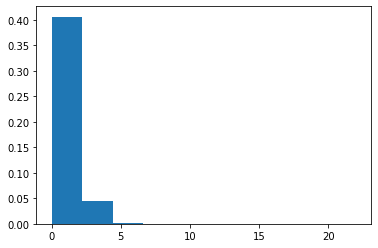

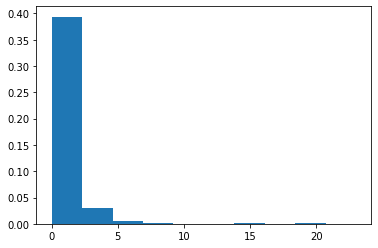

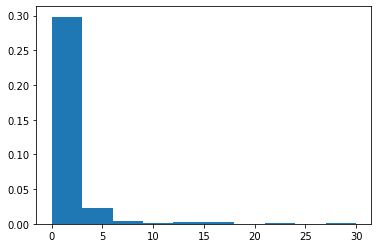

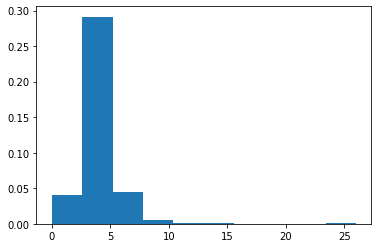

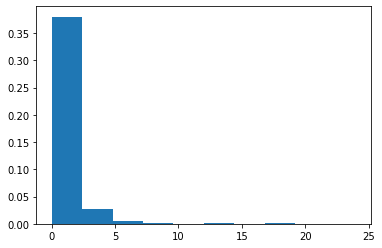

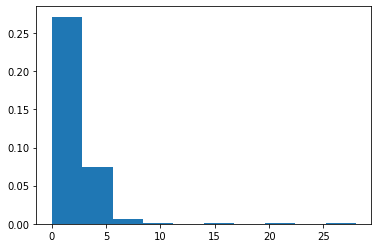

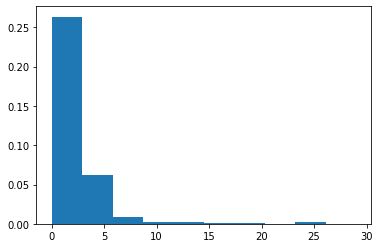

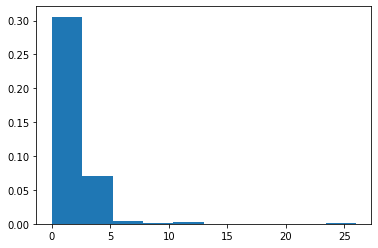

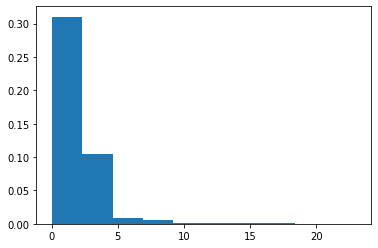

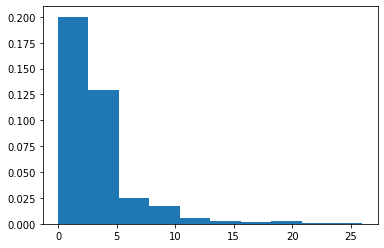

In [38]:
import matplotlib.pyplot as plt
import numpy as np

feature_extractor = tf.keras.Model(inputs=model.input[0], outputs=model.get_layer('main_out').output)

feats = feature_extractor.predict(x_test)

feats[feats >  0.5] = 1
feats[feats <= 0.5] = 0

count = {i:[] for i in range(10)}
for i in range(len(feats)):
    x = feats[i]
    y = y_test[i]
    c = prototypes[int(y)]
    count[int(y)].append( ((x - c)**2).sum(axis=0) )

for k in range(10):
    #print("min dist : ", min(count[k]))
    #print("max dist : ", max(count[k]))
    #print("mean dist : ", sum(count[k]) / len(count[k]))    
    h = sorted(np.array(count[k]))
    plt.hist(h, density=True)
    plt.show()

In [61]:
#**************************************************************************
#********* BUILD_INFORMATION-EXTREME_DECISION_BOUNDARIES ******************
#**************************************************************************

import math

class InformationExtremeСlassifier:

    def __init__(self, etalons=None, radiuses=None):
        self.etalons   = None
        self.radiuses  = None
        if etalons is not None :
            self.etalons  = etalons
            self.class_num   = len(etalons)
            self.feature_num = len(etalons[0])
        if radiuses is not None :
            self.radiuses = radiuses

    def compute_etalons(self, X_train, y_train):
        self.class_num = len( np.unique(y_train) )
        self.feature_num = len(X_train[0])
        self.counter = { i: 0 for i in range(self.class_num)}
        self.etalons = np.zeros((self.class_num, self.feature_num))
        self.center = np.zeros(self.feature_num)
        self.n = len(X_train)
        for i in range(self.n):
            x = X_train[i]
            class_id = y_train[i]
            self.etalons[class_id] = self.etalons[class_id] + x
            self.center = self.center + x
            self.counter[class_id] = self.counter[class_id] + 1
        self.center = self.center / self.n
        for c in range(self.class_num):
            corrected_counter = max(self.counter[c], 1)
            self.etalons[c] = self.etalons[c] / corrected_counter
            self.etalons[c] = self.etalons[c] - self.center[c] 
            self.etalons[c][ self.etalons[c]  > 0 ] = 1
            self.etalons[c][ self.etalons[c] <= 0 ] = 0
        return self.etalons

    def compute_max_radiuses(self, ):
        self.max_radius = np.ones(self.class_num)*self.feature_num
        for c in range(self.class_num):
            for k in range(self.class_num):
                distance = self.get_distance(self.etalons[c], self.etalons[k])
                if c != k :
                    if distance < self.max_radius[c] :
                        self.max_radius[c] = distance
        print("self.max_radius = ", self.max_radius)

    def criterion(self, fpr, fnr, sen, spe):
        com1 = com2 = com3 = com4 = 0
        if fpr+spe > 0 :
            com1 = fpr/(fpr+spe)
            com1 = com1*math.log2(com1) if com1>0 else 0
            com2 = spe/(fpr+spe)
            com2 = com2*math.log2(com2) if com2>0 else 0
        if fnr+sen > 0 :
            com3 = fnr/(fnr+sen)
            com3 = com3*math.log2(com3) if com3>0 else 0
            com4 = sen/(sen+fnr)
            com4 = com4*math.log2(com4) if com4>0 else 0
        return 1 + 0.5*(com1+com2+com3+com4)

    def get_distance(self, b1, b2):
        return np.count_nonzero(b1!=b2)

    def compute_distance_matrix(self, X_train):
        self.n = len(X_train)
        self.counter = { i: 0 for i in range(self.class_num)}
        for i in range(self.n):
            class_id = y_train[i]
            self.counter[class_id] = self.counter[class_id] + 1

        self.dist_matrix = np.zeros((self.class_num, self.n))
        for i in range(self.n):
            x = X_train[i]
            for c in range(self.class_num):
                e = self.etalons[c]
                self.dist_matrix[c][i] = self.get_distance(x, e)

    def optimize_radiuses(self, X_train, y_train):
        self.n = len(X_train)
        self.radiuses = np.zeros(self.class_num)
        fpr = fnr = sen = spe = 0
        for c in range(self.class_num):
            с2с = np.sort(self.dist_matrix[c][y_train==c])
            с2n = np.sort(self.dist_matrix[c][y_train!=c])
            nn = min(self.counter[c], len(с2n))
            с2n = с2n[0:nn]
            E_max = 0
            for r in range(self.feature_num):
                sen = len(с2с[с2с<r])
                fpr = self.counter[c] - sen
                fnr = len(с2n[с2n<r])
                spe = self.counter[c] - fnr
                sen = sen/self.counter[c]
                fpr = fpr/self.counter[c]
                fnr = fnr/self.counter[c]
                spe = spe/self.counter[c]
                E = self.criterion(fpr, fnr, sen, spe)
                if sen > 0.5 and spe > 0.5 and r < self.max_radius[c]:
                     if E > E_max :
                         E_max = E
                         self.radiuses[c] = r
            print( "radius    ["+str(c)+"] : "+ str(self.radiuses[c]) )
            print( "criterion ["+str(c)+"] : "+ str(E_max) )
            print( "*****************************")
  
    def fit(self, X_train, y_train):
        self.n = len(X_train)
        if self.etalons is None :
            self.compute_etalons(X_train, y_train)
        self.compute_max_radiuses()
        self.compute_distance_matrix(X_train)
        self.optimize_radiuses(X_train, y_train)
        return self.etalons, self.radiuses

    def predict(self, x_test):
        result = []
        for j in range(len(x_test)):
            u = np.zeros(self.class_num)
            for c in range(self.class_num):
                e = self.etalons[c]
                dist = self.get_distance(x_test[j], e)
                u[c] = 1 - dist/self.radiuses[c]
                #u = np.exp(u)
        #u /= np.sum(u)
        #return u
            result.append( np.argmax(u) )
        result = np.array(result)
        return result


In [62]:
classifier = InformationExtremeСlassifier() #etalons=prototypes)

features = feature_extractor.predict(x_train)

features[features>0.5] = 1
features[features<=0.5] = 0

classifier.fit(features, y_train)

self.max_radius =  [26. 30. 28. 25. 28. 26. 27. 25. 26. 26.]
radius    [0] : 6.0
criterion [0] : 0.9956832456701418
*****************************
radius    [1] : 17.0
criterion [1] : 0.9913095021960767
*****************************
radius    [2] : 20.0
criterion [2] : 0.9860621794443958
*****************************
radius    [3] : 13.0
criterion [3] : 0.9948324098720861
*****************************
radius    [4] : 12.0
criterion [4] : 0.9691634016403078
*****************************
radius    [5] : 17.0
criterion [5] : 0.9932602252112079
*****************************
radius    [6] : 19.0
criterion [6] : 0.9869595886603308
*****************************
radius    [7] : 14.0
criterion [7] : 0.984582232320542
*****************************
radius    [8] : 15.0
criterion [8] : 0.9946139415513137
*****************************
radius    [9] : 20.0
criterion [9] : 0.9816941961797274
*****************************


(array([[0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1.],
        [0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
         0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
         1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
         1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,

In [63]:
#**************************************************************************
#**************************** SAVE_RADIUSES *******************************
#**************************************************************************
from numpy import savetxt

# save to csv file
savetxt('/content/gdrive/MyDrive/radiuses.csv', classifier.radiuses, delimiter=',')

In [67]:
from sklearn.metrics import f1_score

features = feature_extractor.predict(x_test)

features[features>0.5] = 1
features[features<=0.5] = 0

y_pred = classifier.predict(features)

f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='micro')

(0.9949681209223888, 0.995)